In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from utilities import*

In [1]:
def show_img(img, label):
    w, h = int(img.shape[0]/2), int(img.shape[1]/2)
    cv2.namedWindow(label, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(label, (h, w))
    cv2.imshow(label, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [2]:
def rotate(img, angle_degrees):

    theta = np.radians(angle_degrees)

    old_x, old_y = img.shape[0], img.shape[1]

    new_x = round(abs(old_y*np.sin(theta)) + abs(old_x*np.cos(theta)))
    new_y = round(abs(old_y*np.cos(theta)) + abs(old_x*np.sin(theta)))
    new_centre = (round(new_x/2), round(new_y/2))

    new_img = np.empty((int(new_x), int(new_y), img.shape[2]), dtype=np.uint8)
    
    rot_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    
    for i in range(0, int(new_x)-1):
        for j in range(0, int(new_y)-1):

            # Translate to apply rotation by centre
            x = new_centre[0] - i
            y = new_centre[1] - j

            # Perform backward mapping to obtain pixels
            new_img[i, j] = nn_interpolate(img, x, y, rot_matrix)
    return new_img


def nn_interpolate(img, x, y, matrix):

    # Invert the matrix to perform reverse rotation
    matrix = np.linalg.inv(matrix)
    x, y, _ = matrix @ np.array([x, y, 1])

    centre = (round(img.shape[0]/2), round(img.shape[1]/2))

    # Translate to the same coordinates
    x = centre[0] - x
    y = centre[1] - y

    x =  round(x)
    y =  round(y)

    # Don't interpolate pixels outside the image boundaries
    if x > img.shape[0]-1:
        return np.array([0, 0, 0], dtype=np.uint8)
    if x < 0:
        return np.array([0, 0, 0], dtype=np.uint8)
    if y > img.shape[1]-1:
        return np.array([0, 0, 0], dtype=np.uint8)
    if y < 0:
        return np.array([0, 0, 0], dtype=np.uint8)
        
    return img[int(x), int(y)]


def skew(img, angle_degrees):

    theta = np.radians(angle_degrees)

    x, y = img.shape[0], img.shape[1]
    new_y =  y + np.ceil(x*np.tan(theta))

    new_img = np.empty((int(x), int(new_y), img.shape[2]), dtype=np.uint8)

    skew_matrix = np.array([
        [1, 0, 0],
        [np.tan(theta), 1, 0],
        [0, 0, 1]
    ])

    for i in range(0, x):
        for j in range(0, y):
            new_x, new_y, _ = skew_matrix @ np.array([i, j, 1])
            new_img[int(new_x), int(new_y)] = img[i, j]
    return new_img

In [5]:
img = cv2.imread('Dataset/DatasetA/car-1.jpg')
print(img.shape)
show_img(img, 'Original')

(256, 256, 3)


In [5]:
r_img = rotate(img, 45)
print(r_img.shape)
show_img(r_img, 'Rotated')

(362, 362, 3)


In [6]:
skewed_img = skew(img, 20)
print(skewed_img.shape)
show_img(skewed_img, 'Skewed')

(256, 350, 3)


In [7]:
def create_name(name, path):
    img = Image.new(mode='RGB', size=(256,256), color='yellow')
    font = ImageFont.truetype('arial.ttf', 72)

    draw = ImageDraw.Draw(img)
    draw.text((100,100), name, font=font, fill='black')
    img.save(path)
    return img

In [6]:
name = np.array(create_name('Hai', 'name.png'))
show_img(name, 'Name')

In [9]:
name1 = rotate(name, 30)
show_img(name1, 'Rotated 30')

In [11]:
name2 = rotate(name, 60)
show_img(name2, 'Rotated 60')

In [12]:
name3 = rotate(name, 120)
show_img(name3, 'Rotated 120')

In [13]:
name4 = rotate(name, -50)
show_img(name4, 'Rotated -50')

In [14]:
name5 = skew(name, 10)
show_img(name5, 'Skew 10')

In [21]:
name6 = skew(name, 40)
show_img(name6, 'Skew 40')

In [22]:
name7 = skew(name, 60)
show_img(name7, 'Skew 60')

In [4]:
def add_border(img):
    x, y = img.shape[0], img.shape[1]

    # Mirror the first row
    new_img = np.insert(img, 0, 0, axis=0)    
    new_img[0, :] = new_img[1, :]

    x = new_img.shape[0]
    # Mirror the bottom row
    new_img = np.insert(new_img, x-1, 0, axis=0)
    new_img[x-1, :] = new_img[x-2, :]

    # Mirror the first column
    new_img = np.insert(new_img, 0, 0, axis=1)
    new_img[:, 0] = new_img[:, 1]

    y = new_img.shape[1]
    # Mirror the last column
    new_img = np.insert(new_img, y-1, 0, axis=1)
    new_img[:, y-1] = new_img[:, y-2]
    return new_img

def remove_border(img):

    # Remove the first and bottom rows
    new_img = np.delete(img, 0, axis=0)
    new_img = np.delete(new_img, new_img.shape[0]-1, axis=0)
    
    # Remove the leftmost and rightmost column
    new_img = np.delete(new_img, 0, axis=1)
    new_img = np.delete(new_img, new_img.shape[1]-1, axis=1)
    return new_img


def apply_kernel(img, kernel, gray_scale):

    # Add border for smoothing edge pixels
    img = add_border(img)

    x, y = img.shape[0], img.shape[1]

    if gray_scale == 0:
        new_img = np.empty((x, y, 3), dtype=np.uint8)
        for i in range(1, x-1):
            for j in range(1, y-1):

                # Multiply the 3x3 kernel with 3x3 neighbors
                center = (kernel[1,1] * img[i, j]).astype(int)
                nw = (kernel[0,0] * img[i-1, j-1]).astype(int)
                n = (kernel[0,1] * img[i-1, j]).astype(int)
                ne = (kernel[0,2] * img[i-1, j+1]).astype(int)
                e = (kernel[1,2] * img[i, j+1]).astype(int)
                se = (kernel[2,2] * img[i+1, j+1]).astype(int)
                s = (kernel[2,1] * img[i+1, j]).astype(int)
                sw = (kernel[2,0] * img[i+1, j-1]).astype(int)
                w = (kernel[1,0] * img[i, j-1]).astype(int)

                # Find the mean of the sum
                r = center[0] + nw[0] + n[0] + ne[0] + e[0] + se[0] + s[0] + sw[0] + w[0]
                g = center[1] + nw[1] + n[1] + ne[1] + e[1] + se[1] + s[1] + sw[1] + w[1]
                b = center[2] + nw[2] + n[2] + ne[2] + e[2] + se[2] + s[2] + sw[2] + w[2]

                # Threshold the colour intensities
                r = r if r > 0 and r < 255 else 255 if r > 255 else 0
                g = g if g > 0 and g < 255 else 255 if g > 255 else 0
                b = b if b > 0 and b < 255 else 255 if b > 255 else 0
                new_img[i, j] = np.array([r, g, b], dtype=np.uint8)
                
    else:
        img = to_grayscale(img)
        new_img = np.empty((x, y, 1), dtype=np.uint8)
        for i in range(1, x-1):
            for j in range(1, y-1):
                center = (kernel[1,1] * img[i, j]).astype(int)
                nw = (kernel[0,0] * img[i-1, j-1]).astype(int)
                n = (kernel[0,1] * img[i-1, j]).astype(int)
                ne = (kernel[0,2] * img[i-1, j+1]).astype(int)
                e = (kernel[1,2] * img[i, j+1]).astype(int)
                se = (kernel[2,2] * img[i+1, j+1]).astype(int)
                s = (kernel[2,1] * img[i+1, j]).astype(int)
                sw = (kernel[2,0] * img[i+1, j-1]).astype(int)
                w = (kernel[1,0] * img[i, j-1]).astype(int)
                
                result = center + nw + n + ne + e + se + s + sw + w
                pixel = result[0] if result[0] > 0 and result[0] < 255 else 255 if result[0] > 255 else 0
                new_img[i, j] = pixel
    new_img = remove_border(new_img)
    return new_img


def to_grayscale(img):

    x, y = img.shape[0], img.shape[1]

    new_img = np.empty((x, y, 1), dtype=np.uint8)

    # Coefficients for each color
    r_c = 0.2126
    g_c = 0.7152
    b_c = 0.0722

    for i in range(0, x):
        for j in range(0, y):
            r = img[i, j][0]
            g = img[i, j][1]
            b = img[i, j][2]
            pixel = np.round((r_c * r) + (g_c * g) + (b_c * b))
            new_img[i, j] = int(pixel)

    return new_img

In [23]:
kernel_mean = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

kernel_mean = kernel_mean/kernel_mean.size

mean_img = apply_kernel(img, kernel_mean, 0)
show_img(mean_img, 'Mean Filter')
cv2.imwrite('figures/Mean Filter.jpg', mean_img)

True

In [8]:
kernel_A = np.array([
    [1, 2, 1],
    [2, 4, 2],    
    [1, 2, 1]
])

sum_A = np.sum(kernel_A)
kernel_A = kernel_A/sum_A

kernel_B = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
])

In [9]:
# Kernel A
A_img = apply_kernel(img, kernel_A, 0)
show_img(A_img, 'Kernel A')
cv2.imwrite('figures/img_A.jpg', A_img)

True

In [ ]:
# Kernel B
B_img = apply_kernel(img, kernel_B, 1)
show_img(B_img, 'Kernel B')
cv2.imwrite('figures/img_B.jpg', B_img)

In [ ]:
# Kernel A followed by Kernel A
A_A = apply_kernel(img, kernel_A, 1)
A_A = apply_kernel(img, kernel_A, 1)
show_img(A_A, 'img_AA')
cv2.imwrite('figures/img_AA.jpg', A_A)

In [ ]:
# Kernel A followed by Kernel B
A_B = apply_kernel(img, kernel_A, 1)
A_B = apply_kernel(img, kernel_B, 1)
show_img(A_B, 'img_AB')
cv2.imwrite('figures/img_AB.jpg', A_B)

In [33]:
# Kernel B followed by Kernel A
gray = to_grayscale(img)
B_A = apply_kernel(img, kernel_B, 1)
B_A = apply_kernel(img, kernel_A, 1)
show_img(B_A, 'img_BA')
cv2.imwrite('figures/img_BA.jpg', B_A)

True

In [5]:
def create_hist(img, flag):

    # For coloured images
    if img.shape[2] == 3:

        # Get each intensity and their corresponding count
        r, r_count = np.unique(img[:, :, 0], return_counts=True)
        g, g_count = np.unique(img[:, :, 1], return_counts=True)
        b, b_count = np.unique(img[:, :, 2], return_counts=True)

        fig, ax = plt.subplots(3,1)
        fig.tight_layout()

        rhist = ax[0].bar(r, r_count)
        ax[0].set_title('Red Histogram')
        ax[0].set_ylabel('Count')

        ghist = ax[1].bar(g, g_count)
        ax[1].set_title('Green Histogram')
        ax[1].set_ylabel('Count')

        bhist = ax[2].bar(b, b_count)
        ax[2].set_title('Blue Histogram')
        ax[2].set_ylabel('Count')
        fig.show()
        fig.savefig('figures/histogram.png')
        return (rhist, ghist, bhist)


    # For grayscale images
    else:
        intensity, count = np.unique(img[:, :], return_counts=True)

        intensity_filled = np.zeros((256), dtype=np.uint8)
        count_filled = np.zeros((256), dtype=np.uint8)

        # Fill 0 to count in intensity values that are not present
        j = 0
        for i in range(0,256):
            if i != intensity[j] or i > len(intensity):
                intensity_filled[i] = i
            else:
                intensity_filled[i] = j
                count_filled[i] = count[j]
                j += 1

        #Normalize the histogram
        count_filled = count_filled/img.size

        if flag == 1:
            fig, ax = plt.subplots(1,1)
            fig.tight_layout()

            hist = ax.bar(intensity_filled, count_filled)
            ax.set_title('Intensity')
            ax.set_ylabel('Count')
        return (intensity_filled, count_filled)

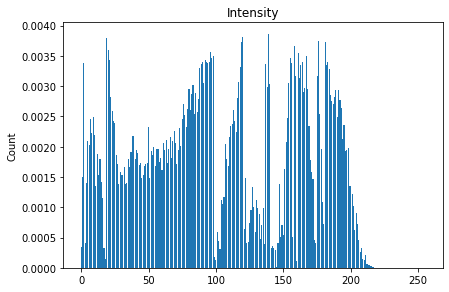

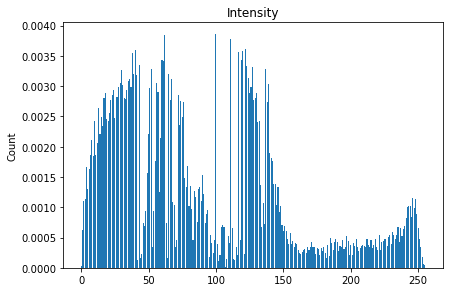

In [19]:
img = cv2.imread('Dataset/DatasetA/face-2.jpg')
img2 = cv2.imread('Dataset/DatasetA/face-1.jpg')
h1 = to_grayscale(img)
h1 = create_hist(h1, 1)
h2 = to_grayscale(img2)
h2 = create_hist(h2, 1)

In [6]:
# def hist_intersection(h1, h2):
#     sm = 0

#     count = np.minimum(h1[1], h2[1])
#     fig, ax = plt.subplots(1,1)
#     fig.tight_layout()

#     hist = ax.bar(h1[0], count)
#     ax.set_title('Intensity')
#     ax.set_ylabel('Count')
#     # sm = sum(min(A,B))
#     return count

def hist_intersection(h1, h2):
    intersection = 0
    #for i in range(len(h1[0])):
    intersection = np.sum(np.minimum(h1[1], h2[1]))

    return intersection

In [43]:
inter = hist_intersection(h1, h2)
inter

0.2072906494140625

In [41]:
def video_intersection(path, n):
  vid = cv2.VideoCapture(path)

  if (vid.isOpened()== False): 
    print("Error opening video stream or file")

  frames = []

  while(vid.isOpened()):
      ret, frame = vid.read()

      if ret==True:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = gray[:, :, np.newaxis]
        frames.append(gray)

        cv2.imshow('frame', gray)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
          for i in range(n):
            h1 = create_hist(frames[i], 0)
            h2 = create_hist(frames[i+1], 0)
            print(hist_intersection(h1, h2))
          break
      else:
        break   

  vid.release()
  cv2.destroyAllWindows()
  return frames

In [42]:
path = 'Dataset/DatasetB.avi'
frames = video_intersection(path, 10)

0.21437872023809523
0.20482568027210882
0.18128188775510207
0.17697704081632654
0.16004995748299317
0.15211787840136054
0.13934948979591838
0.1275908801020408
0.05188403486394558
0.24940210459183676


In [7]:
# Split image into windows
def to_windows(img):
    window_size = 64
    x, y = img.shape[0], img.shape[1]

    windows = []

    for i in range(0, x,  window_size):
        for j in range(0, y, window_size):
            window = img[i:i+window_size, j:j+window_size]
            windows.append(window)

    return windows


# Apply local binary pattern
def apply_lbp(img):

    # Add border to apply for edge pixels
    img = to_grayscale(img)
    img = add_border(img)

    x, y = img.shape[0], img.shape[1]
    new_img = np.empty((x, y, 1), dtype=np.uint8)

    for i in range(1, x-1):
        for j in range(1, y-1):

            # Compare center pixel to neighborhood
            center = img[i, j].astype(int)
            nw = 0 if center > img[i-1, j-1] else 1
            n = 0 if center > img[i-1, j] else 1
            ne = 0 if center > img[i-1, j+1] else 1
            e = 0 if center > img[i, j+1] else 1
            se = 0 if center > img[i+1, j+1] else 1
            s = 0 if center > img[i+1, j] else 1
            sw = 0 if center > img[i+1, j-1] else 1
            w = 0 if center > img[i, j-1] else 1

            # Bit code of the neighbors
            binary_string = [ne, e, se, s, sw, w, nw, n]
            decimal = 0

            # Converrt to decimal
            for k, bit in enumerate(binary_string):
                decimal += bit*(2**k)

            new_img[i, j] = decimal

    # Remove the added border
    new_img = remove_border(new_img)
    return new_img

In [47]:
img = cv2.imread('Dataset/DatasetA/car-1.jpg')

In [51]:
windows = to_windows(img)

for window in windows:
    lbp = apply_lbp(window)
    hist = create_hist(lbp, 0)


In [49]:
img = cv2.imread('Dataset/DatasetA/face-1.jpg')

224
252
252
255
228
251
248
255
255
224
252
224
255
228
252
248


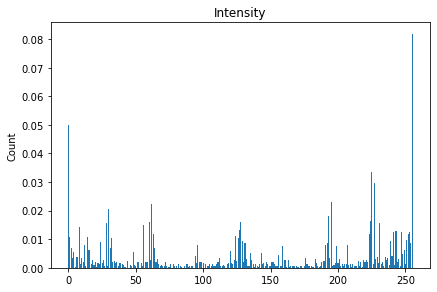

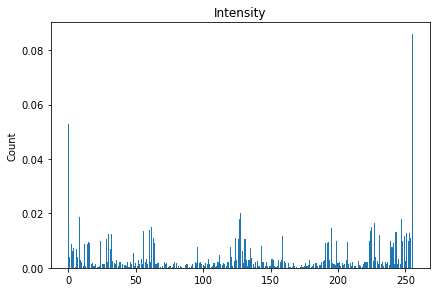

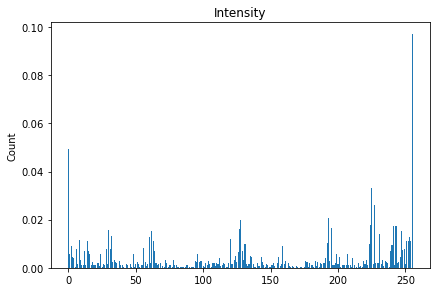

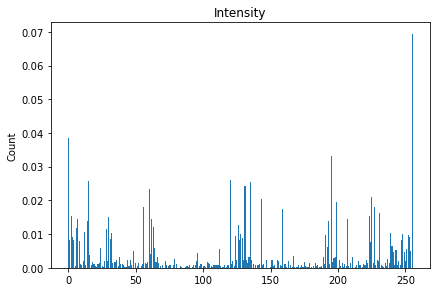

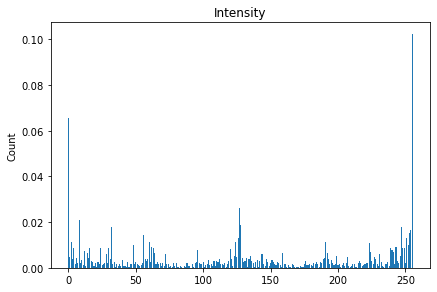

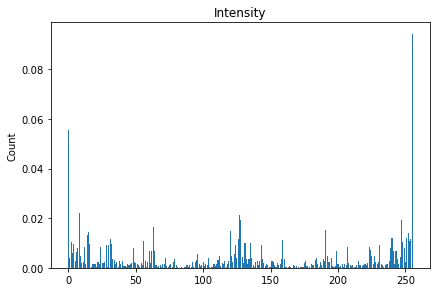

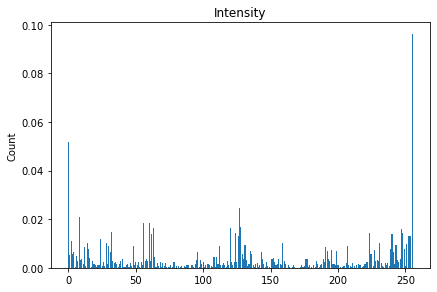

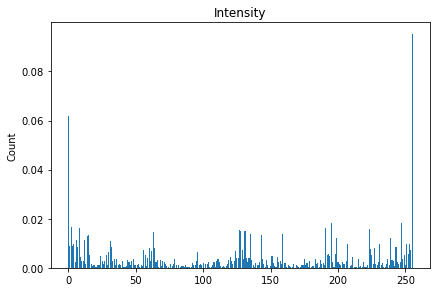

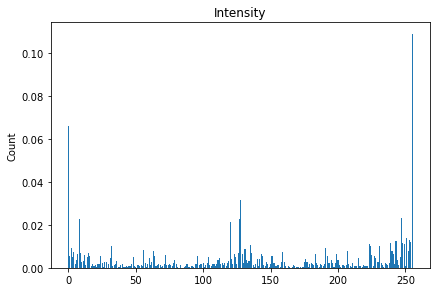

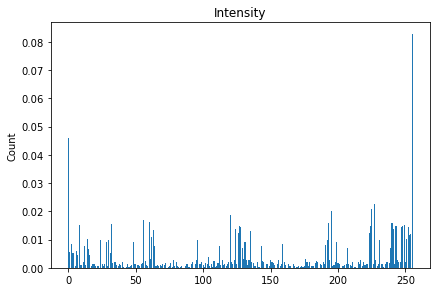

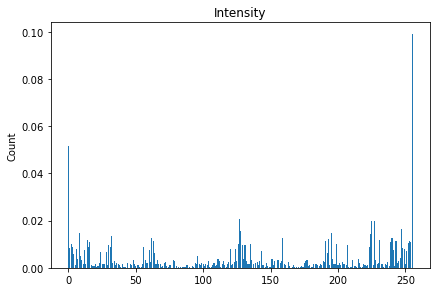

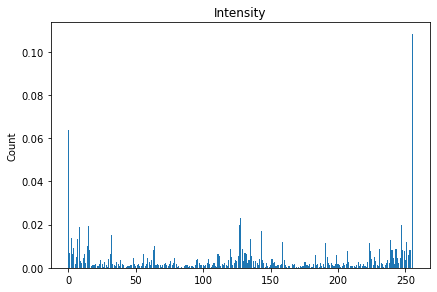

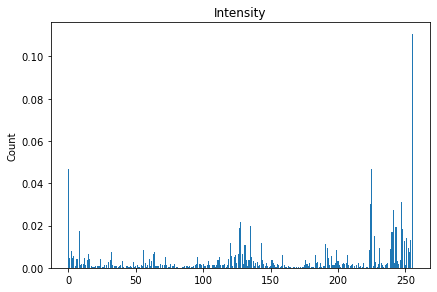

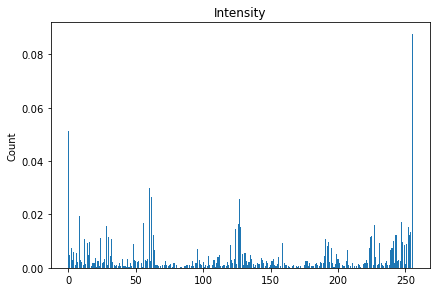

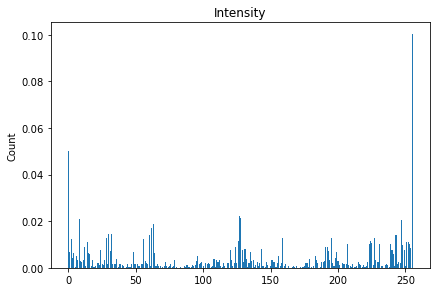

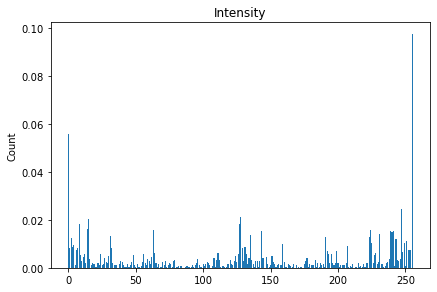

In [27]:
windows = to_windows(img)

for window in windows:
    lbp = apply_lbp(window)
    hist = create_hist(lbp)

In [265]:
# 5C
def get_background(frames):
    frames = np.array(frames)
    x, y, z = frames.shape[1], frames.shape[2], frames.shape[3]

    avg = np.zeros((x, y, z), dtype=np.uint8)
    
    for i in range(x):
        for j in range(y):
            avg[i, j] = np.median(frames[:, i, j]) if z==1 else np.median(frames[:, i, j, :])
    return avg

def get_frames(path, rbg):
    vid = cv2.VideoCapture(path)

    if (vid.isOpened()== False): 
        print("Error opening video stream or file")

    frames = []

    while(vid.isOpened()):
        ret, frame = vid.read()

        if ret==True:
            if rbg==0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = frame[:, :, np.newaxis]
            frames.append(frame)
        else:
            break   
    vid.release()
    cv2.destroyAllWindows()
    return frames

def play_video(frames):
    for frame in frames:
        cv2.imshow('Frame', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
    pass

# 5A
def compute_segmentation(frames, reference_frame, threshold):
    frames = np.array(frames)
    
    new_frames = []
            
    for frame in frames:
        new_frame = np.abs(frame.astype('int16') - reference_frame.astype('int16'))
        new_frame[new_frame < threshold] = 0
        new_frame[new_frame > threshold] = 255
        new_frames.append(new_frame)
    new_frames = np.array(new_frames, dtype=np.uint8)
    return new_frames

# 5B
def segment_previous_frame(frames, threshold):
    frames = np.array(frames)

    new_frames = []
    for i, frame in enumerate(frames):
        if i==0:
            new_frames.append(frame)
            continue
        new_frame = np.abs(frame.astype('int16') - frames[i-1].astype('int16'))
        new_frame[new_frame < threshold] = 0
        new_frame[new_frame > threshold] = 255
        new_frames.append(new_frame)
    new_frames = np.array(new_frames, dtype=np.uint8)
    return new_frames

In [115]:
path = 'Dataset/DatasetC.avi'

In [116]:
frames = get_frames(path, 0)

In [245]:
play_video(frames)

In [118]:
reference_frame = get_background(frames)

In [262]:
show_img(reference_frame, 'bg')

In [268]:
segmented_frames = compute_segmentation(frames, reference_frame, 40)

In [276]:
play_video(segmented_frames)

In [274]:
segmented_frames2 = segment_previous_frame(frames, 20)

In [277]:
play_video(segmented_frames2)

In [ ]:
def video_segmentation(path, reference_frame):
    vid = cv2.VideoCapture(path)

    if (vid.isOpened()== False): 
        print("Error opening video stream or file")

    frames = []

    while(vid.isOpened()):
        ret, frame = vid.read()

        if ret==True:
            #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray = gray[:, :, np.newaxis]
            frames.append(gray)
        
            if len(frames) > 1:
                # 5A
                gray = gray - reference_frame
                # 5B
                #gray = gray - frames[len(frames)-2]
            cv2.imshow('frame', gray)
            
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break   

    vid.release()
    cv2.destroyAllWindows()
    return frames